# Importer les librairies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Fonctions générales

In [2]:
def cohen(x,y, t):
    return (t*np.sqrt((x+y)/(x*y)))

# Importer les données

In [3]:
data = pd.read_csv("Data/titanic.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Questions

## 1. Préparation des données

Remplissez la function `preprocess` ci-dessus. Celle-ci doit:
1. Supprimez les colonnes `PassengerId`, `Name`, `Ticket`, `Cabin`.
2. Supprimez les lignes contenant au moins une valeur manquante.
3. Créer une variable `FamilySize` qui est correspond à `SibSp` + `Parch` + 1. Supprimez les variables `SibSp` et `Parch`.
4. Recalculer le prix du billet `Fare` en divisant `Fare` par `FamilySize`.
5. Encoder les variables qualitatives `Sex`, `Embarked` avec l'argument `drop_first=True`.

In [4]:
def preprocess(data: pd.DataFrame) -> pd.DataFrame:

    """La fonction prépare les données à l'analyse.

    Args:
        data (pd.DataFrame): La dataframe originale

    Returns:
        pd.DataFrame: La dataframe preprocessé et prête à être analysée.
    """

    # Faire une copy de la dataframe originale
    data_preprocessed = data.copy()

    # Supprimez les variables `PassengerId`, `Name`, `Ticket` & `Cabin`
    data_preprocessed = data_preprocessed.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])

    # Supprimez lignes contenant au moins une valeur manquante
    data_preprocessed = data_preprocessed.dropna()

    # Créer une variable `FamilySize` et supprimez les variables `SibSp` et `Parch`
    data_preprocessed["FamilySize"] = data_preprocessed["SibSp"] + data_preprocessed["Parch"] + 1
    data_preprocessed = data_preprocessed.drop(columns=["SibSp", "Parch"])

    # Recalculer le prix du billet
    data_preprocessed["Fare"] = data_preprocessed["Fare"] / data_preprocessed["FamilySize"]

    # Encode (OHE) `Sex` & `Embarked`
    data_preprocessed = pd.get_dummies(
        data_preprocessed,
        columns=["Sex", "Embarked"],
        drop_first=True,
        dtype=int
    )



    # CHECK: NE PAS TOUCHER
    for col in ["PassengerId", "Name", "Ticket", "Cabin", "SibSp", "Parch"]:
        assert col not in data_preprocessed, f"{col} n'a pas été retiré."
    assert data_preprocessed.isna().sum().sum() == 0, "Il reste encore des NaN à supprimer."
    assert "FamilySize" in data_preprocessed.columns, "La colonne `FamilySize` n'a pas été créée."
    assert data_preprocessed.loc[0, "Fare"] == 3.625, "La colonne `Fare` n'a pas été recalculée."
    for col in [col for col in data_preprocessed if col.startswith("Embarked")]:
        assert data_preprocessed[col].nunique() == 2, f"{col} n'a pas été encodé."
    for col in [col for col in data_preprocessed if col.startswith("Sex")]:
        assert data_preprocessed[col].nunique() == 2, f"{col} n'a pas été encodé."

    return data_preprocessed

Le résultat de la function doit vous donner exactement le tableau ci-dessous.

In [5]:
# Preprocess les données à l'aide de la function `preprocess`
data_clean = preprocess(data)
display(data_clean)

,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,3.625000,2,1,0,1
1,1,1,38.0,35.641650,2,0,0,0
2,1,3,26.0,7.925000,1,0,0,1
3,1,1,35.0,26.550000,2,0,0,1
4,0,3,35.0,8.050000,1,1,0,1
...,...,...,...,...,...,...,...,...
885,0,3,39.0,4.854167,6,0,1,0
886,0,2,27.0,13.000000,1,1,0,1
887,1,1,19.0,30.000000,1,0,0,1
889,1,1,26.0,30.000000,1,1,0,0


In [6]:
data_clean.describe()

,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.404494,2.240169,29.642093,20.736106,1.946629,0.636236,0.039326,0.778090
std,0.491139,0.836854,14.492933,37.544783,1.485027,0.481420,0.194506,0.415823
min,0.000000,1.000000,0.420000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,20.000000,7.318750,1.000000,0.000000,0.000000,1.000000
50%,0.000000,2.000000,28.000000,9.225000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,3.000000,38.000000,26.000000,2.000000,1.000000,0.000000,1.000000
max,1.000000,3.000000,80.000000,512.329200,8.000000,1.000000,1.000000,1.000000


## 2. Inférence statistique (4 pts)

**Q1: L'âge moyen des passagers du Titanic est-il le même que l'âge moyen de la population en 1912 (28 ans)?**


1. Identifier la ou les variables d'intérêt et spécifier le type.


Variable *Age*, type *Quantitatif, continue*


2. Réaliser une visualisation appropriée selon la ou les variables.

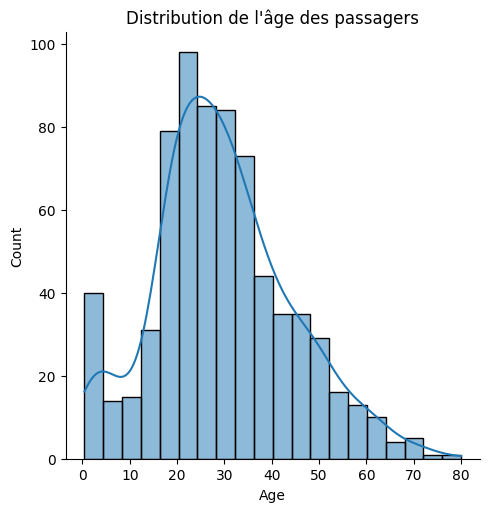

In [7]:
sns.displot(
    data=data_clean,
    x="Age",
    kde=True
)
plt.title("Distribution de l'âge des passagers")
plt.show()

3. Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.


H0: L'âge moyen des passagers est identique à celui de la population en 1912 (28 ans).  
H1: L'âge moyen des passagers est différent de celui de la population en 1912 (28 ans).


4. Identifier le test statistique approprié selon les hypothèses énoncées.


Nous devons réaliser un t-test (car nous n'avons pas l'écart type de la population de 1912) pour comparer la moyenne de l'age de notre échantillon à celle de la population en 1912.

5. Vérifier la validation des assumptions selon le test identifié.


L'échantillon fourni représente un peu plus d'un tiers des passagers du Titanic. A priori cet échantillon n'est pas aléatoire au sens statistique, mais suffisament représentatif de la population du titanic (https://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf).
Nous avons retiré 180 lignes incomplétes.
La taille de l'échantillon est supérieur à 30 et est proche normalement distribué.


6. Calculer la statistique ainsi que la p-valeur.

In [8]:
mean_1912_population_age = 28
print("Moyenne age titanic : ", np.mean(data_clean["Age"]))

t, p_value = stats.ttest_1samp(data_clean["Age"], popmean=mean_1912_population_age)

print("La statistique t est de : " + str(t))
print("La p-valeur associée est de : " + str(p_value))

Moyenne age titanic :  29.64209269662921
La statistique t est de : 3.0233009800374053
La p-valeur associée est de : 0.002590259537786662


7. Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%.

In [9]:
"On rejette l'hypothèse nulle" if p_value < 0.05 else "On ne rejette pas l'hypothèse nulle"

"On rejette l'hypothèse nulle"


8. Interpréter le résultat et évaluer la taille de l'effet.

In [16]:
nb_Titanic_Population = data_clean["Age"].std()
#Estimation de la population mondiale en 1912, source : https://en.wikipedia.org/wiki/World_population
nb_World_Population_1912 = 1800000000
d = cohen(nb_Titanic_Population, nb_World_Population_1912, t)
print("La taille de l'effet est de selon la formule du d de Cohen : " + str(d))

La taille de l'effet est de selon la formule du d de Cohen : 0.7941512902666406


Selon les interprétations de la table de Cohen, cette valeur indique une forte d'taille d'effet

**Q2: La survie dépend-elle de la classe du passager?**

1. Identifier la ou les variables d'intérêt et spécifier le type.
2. Réaliser une visualisation appropriée selon la ou les variables.
3. Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
4. Identifier le test statistique approprié selon les hypothèses énoncées.
5. Vérifier la validation des assumptions selon le test identifié.
6. Calculer la statistique ainsi que la p-valeur.
7. Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%.
8. Interpréter le résultat et évaluer la taille de l'effet.

**Q3: Existe-t-il une différence d'âge entre les passagers qui ont survécu et les passagers décédés?**

1. Identifier la ou les variables d'intérêt et spécifier le type.
2. Réaliser une visualisation appropriée selon la ou les variables.
3. Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
4. Identifier le test statistique approprié selon les hypothèses énoncées.
5. Vérifier la validation des assumptions selon le test identifié.
6. Calculer la statistique ainsi que la p-valeur.
7. Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%.
8. Interpréter le résultat et évaluer la taille de l'effet.

**Q4: Existe-t-il une relation entre l'âge des passagers et le prix des billets?**

1. Identifier la ou les variables d'intérêt et spécifier le type.
2. Réaliser une visualisation appropriée selon la ou les variables.
3. Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
4. Identifier le test statistique approprié selon les hypothèses énoncées.
5. Vérifier la validation des assumptions selon le test identifié.
6. Calculer la statistique ainsi que la p-valeur.
7. Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%.
8. Interpréter le résultat et évaluer la taille de l'effet.

### Pour chacune des questions 1 à 4 ci-dessus, argumenter de manière statistique en effectuant chacune des étapes suivantes:
1. Identifier la ou les variables d'intérêt et spécifier le type.
2. Réaliser une visualisation appropriée selon la ou les variables.
3. Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
4. Identifier le test statistique approprié selon les hypothèses énoncées.
5. Vérifier la validation des assumptions selon le test identifié.
6. Calculer la statistique ainsi que la p-valeur.
7. Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%.
8. Interpréter le résultat et évaluer la taille de l'effet.

Quelques liens utiles pour la taille de l'effet:
* [https://rpsychologist.com/cohend/](https://rpsychologist.com/cohend/)
* [https://datatab.net/tutorial/effect-size-independent-t-test](https://datatab.net/tutorial/effect-size-independent-t-test)
* [https://www.simplypsychology.org/effect-size.html](https://www.simplypsychology.org/effect-size.html)

## 3. Data mining (2 pts)

**Q1: Effectuer une analyse statistique à l'aide de la régression logistique avec comme variable dépendente la variable `Survived`. Interpréter les coefficients et discuter de leur importance statistique en vous appuyant sur leur p-valeur.**

**Q2: Effecter une analyse statistique à l'aide d'un arbre de classification avec comme variable dépendente la variable `Survived` et une profondeur maximale de 4. Visualiser l'arbre et expliquer quelques décisions.**

**Conclusion: Interpréter les résultats des deux analyses statistiques et résumer les points importants de votre étude.**

# Sources statistiques  
https://www.researchgate.net/figure/Effect-size-Cramers-V-for-the-survival-of-Titanic-passengers-by-class-position-Titanic_tbl1_370188870

